##Project title: 
#**Machine Learning Approach to Ranking Toxic Comments**
**Authors: Chenxi Deng, Guanlin Li**



Project source: https://www.kaggle.com/c/jigsaw-toxic-severity-rating

Project description: https://www.kaggle.com/c/jigsaw-toxic-severity-rating/overview/description

Project aim: Given a pair of comment, predict the relative toxicity of the comment.

##1. Importing Files and Libraries:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# general libraies
import gc
import re
import numpy as np
import string
from tqdm import tqdm 
import os  
import warnings  
warnings.filterwarnings("ignore")
from collections import defaultdict  
from itertools import cycle  
# dataframe
import pandas as pd, numpy as np
from pandas import option_context
# visualization
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#nltk
import nltk
from nltk import ngrams
from nltk.corpus import wordnet, stopwords
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator  # word cloud building library

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn import preprocessing
# tensorflow 
import tensorflow as tf
import tensorflow_hub as hub

## 2. Reading Data:
1. train_file = the training dataset
2. test_file = the test dataset

In [ ]:
train_file="/content/gdrive/MyDrive/IP_Paris_Class_P2/Mining of large dataset/all_in_one_jigsaw.csv"
#test_file="/content/gdrive/MyDrive/IP_Paris_Class_P2/Mining of large dataset/3-validation-data/comments_to_score.csv"
test_file="/content/gdrive/MyDrive/IP_Paris_Class_P2/Mining of large dataset/3-validation-data/validation_data.csv"

In [ ]:
# read training and test datasets with pandas read_csv
train_data = pd.read_csv(train_file)
test_data=pd.read_csv(test_file)

### 2.1 Looking at the data
The training data contains a row per comment, with an id, the text of the comment, and six attributes (**'toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'**)  linked to toxicity of the comment. This dataset also contains a column containing pre-processed texts of the comments. However, we have decided on an alternative strategy for pre-processing data. The column is not used for subsequent analyses.  

This dataset was collected from 2 past Kaggle Jigsaw competitions. These include:
1. Jigsaw Unintended Bias in Toxicity Classification
2. Toxic Comment Classification



In [ ]:
train_data.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,dataset,comment_text_processed
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,explanation why the edits made under my userna...
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,d'aww he matches this background colour i'm se...
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,hey man i'm really not trying to edit war it's...
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,more i can't make any real suggestions on impr...
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,you sir are my hero any chance you remember wh...


In [ ]:
# remove the column that contains no useful information 
train_data = train_data.drop(columns=['Unnamed: 0'])

The training dataset contains a total of 2,223,065 comments. 

In [ ]:
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,2.223065e+06,2.223065e+06,2.223065e+06,2.223065e+06,2.223065e+06,2.223065e+06
mean,1.021933e-01,5.002512e-03,1.795457e-02,8.657584e-03,7.806368e-02,2.123378e-02
std,2.088633e-01,3.669255e-02,9.525246e-02,5.001892e-02,1.811210e-01,8.066601e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


<Figure size 800x1000 with 0 Axes>

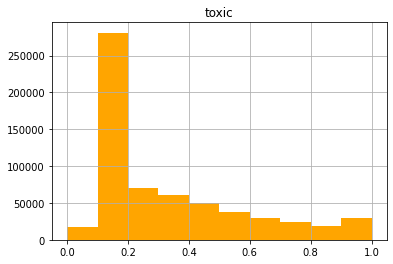

<Figure size 800x1000 with 0 Axes>

In [ ]:
df_toxic = train_data.loc[((train_data["toxic"] >0.0))]
df_toxic.hist(column='toxic', color = 'orange')
figure(figsize=(8, 10), dpi=100)
 

We used the validation dataset from an active kaggle competition "Jigsaw Rate Severity of Toxic Comments" as our test data. This dataset contains pairs of comments, one of which is more toxic than the other. These ratings were determined by moderators. A pair of comments could have been rated by more than one moderator. This dataset will be used to measure how well our model performs, based on average agreement with annotators. That means, the pair receives a 1 if our ranking matches that of the moderators, and a 0 if it does not match.



In [ ]:
test_data.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


The dataset contains 30,108 comment pairs.

In [ ]:
test_data.describe()

,worker
count,30108.000000
mean,374.847748
std,213.552862
min,0.000000
25%,193.000000
50%,372.000000
75%,558.000000
max,752.000000


In [ ]:
print(f'Train data is of shape: {train_data.shape}')
print(f'Test data is of shape: {test_data.shape}')

Train data is of shape: (2223065, 10)
Test data is of shape: (30108, 5)


## 3. Exploratory Data Analysis:

### 3.1 Data visualisation - training dataset


In [ ]:
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'dataset', 'comment_text_processed'],
      dtype='object')

In [ ]:
# get the value sum of all attribute per comment 
def get_sum(row):
  return sum([row['toxic'], row['severe_toxic'], row['obscene'], row['threat'], row['insult'], row['identity_hate']])
train_data['level'] = train_data.apply(lambda x: get_sum(x), axis=1)

In [ ]:
# Top 20 most toxic comments in training data, determined by value sum of all attribute 
train_data_ranked =train_data.sort_values('level',ascending = False).head(20)
with option_context('display.max_colwidth', 200):
    display(train_data_ranked["comment_text"].to_frame())

,comment_text
38578,"fuck you honkey, why you hatin' on blacks? You fucking pussy geek nazi, I'll come to your house and rape your mom because I've got a big black dick in her tight white ass, honkey"
166069,Dick Cheney will fucking kill all of those goddam democrats! I fucking hate those goddam liberals. I just killed two of them myself. And me and a few of my buddies are going to go to a few of thos...
7299,"You're a stupid cunt \n\nFuck you dumb arse, your mum has a hairy cunt and I hope and pray that you die, no, fuck that, I wish you would die, if I had three wishes, one of them would be to have yo..."
100222,Urgent!!!! \n\nMind yo own fucken buisiness stop fucken changing my shit fuck you!!! eat a mutha fucken dick. Ill beat yo ass come find me nigga i go here!
222326,"EAT SHIT AND DIE YOU FAGGOT NAZI LOVING JEW HATING MOTHERFUCKER!!! I'LL MURDER YOU IN YOUR OWN HOME YOU FAGGOT!! I WILL FIND YOU, SLIT YOUR THROAT, DRINK YOUR BLOOD, PISS DOWN YOUR MOUTH, CUT YOUR..."
33951,"GO FUCK YOURSELF BITCH. I HATE YOUR SOULD. MOTHER FUCKER, WHO THE HELL DO YOU THINK YOU ARE. I WILL STOMP ON YOUR NECK UNTIL YOU FUCKING DIE. DO YOU HEAR ME, EVERY TIME YOU MAKE A CHANGE, A KI..."
210275,kill ya niggas i hate fuckin black people klue kluxs klann hell yea!!!!!!!!!!!!!!!!!!
99819,Glenn Beck is a faggot. He likes dick in his ass. I'd like to cut his head off.
210785,"T IS PEOPLE LIKE YOU THAT MAKE WIKIPEDIA HORRIBLE. BLOCKING SCHNITZELMANGREEK FOR NO REASON!GET A LIFE YOU LOSER OR I'L KILL YOU, YOU WIFE, AND CHILDREN!!!!BURN IN HELL!!I LIGHT YOUR CORPSE LIKE F..."
133551,"and your little faggot boy Propol, pray, pray little wonk that I don't find your little ass and kill you"


In [ ]:
# Top 20 least toxic comments in training data, determined by value sum of all attribute 
train_data_ranked =train_data.sort_values('level',ascending = True).head(20)
with option_context('display.max_colwidth', 200):
    display(train_data_ranked["comment_text"].to_frame())

,comment_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo..."
1148047,"And Chad. These officers...they deserve the best from us. They deserve our full 100 percent support. They deserve hugs, advocacy, our abilities to stand with them for safety and health of communit..."
1148046,"This is a great example of why our health care system should become ""two tier"" pay more for ""better"" service.\n( although we are already two tier in many services , we just don't want to talk abou..."
1148045,"Squandered? It is the cleanest running biomass facility in America and possibly the world and is studied be college kids across the country. Just like anything that is green or organic, it costs m..."
1148044,"The state should be blind to a person's complexion, surname or disingenuous self-identification. DNA analytical services such as Ancestry.com show that most of us are a mosaic or composition of e..."
1148043,Does it seem baffling to anyone else that rebuilding a playground takes over a million dollars? I'd like to see a line item budget.
1148042,"""Tragically impaired""? Isn't just like you kick good folks when they are ill. Is that what your Lord Jesus would do? Perhaps one day you'll wake up to cancer in your prostate, or multiple myeloma ..."
1148041,Also Senator Brian Schatz.
1148040,Don't tell me people in Vancouver can complain about the federal govt's approval of the Kinder Morgan pipeline expansion based on any possible negative impact on house prices. Vancouver house pric...
1148039,How original. Nobody's done that before.


We want to obtain the number of comments linked to each attribute.

In [ ]:
# a comment can have more than one attribute 
# we drop other columns other than attribute labels 
train_data_labels = train_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
train_data_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Replace any non-zero values with 1 for counting
df = train_data_labels.mask(train_data_labels > 0, 1)
df1= df.sum(axis=0) # sum all values for each column 
df1

toxic            619138.0
severe_toxic     117797.0
obscene          175183.0
threat           118870.0
insult           514552.0
identity_hate    243635.0
dtype: float64

Among toxic comments, the general "toxic" label is the most prevalent, followede by "insult". 

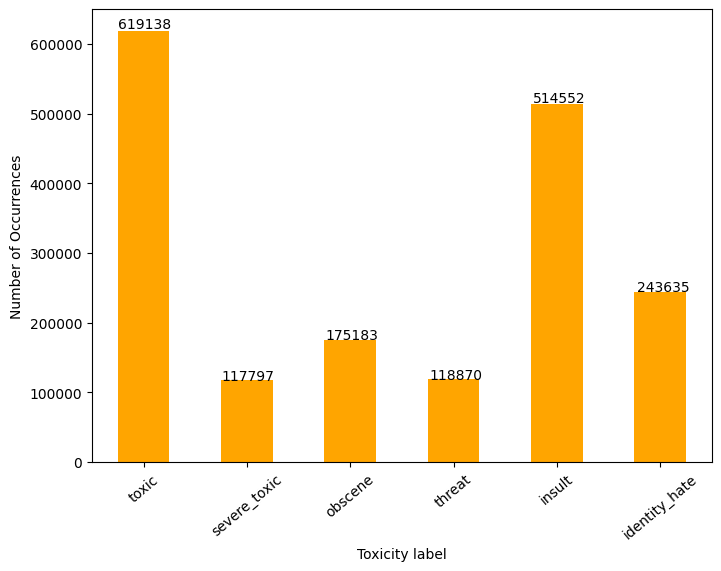

In [ ]:
# plot the number of occurrences per attribute. 
def plt_no_occurrences(dataset):
  figure(figsize=(8,6), dpi=100)
  df_plot = dataset.plot.bar(color="orange", rot = 40)
  df_plot.set_xlabel('Toxicity label')
  df_plot.set_ylabel('Number of Occurrences')
  for p in df_plot.patches:
      df_plot.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))
plt_no_occurrences(df1)

In [ ]:
#plot the distribution of toxicity attributes in train data
def plt_attr_distribution(attrs, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for attr in attrs:
        sns.distplot(data[attr],kde=True,hist=False, bins=240, label=attr)
    plt.xlabel('')
    plt.legend()
    plt.show()

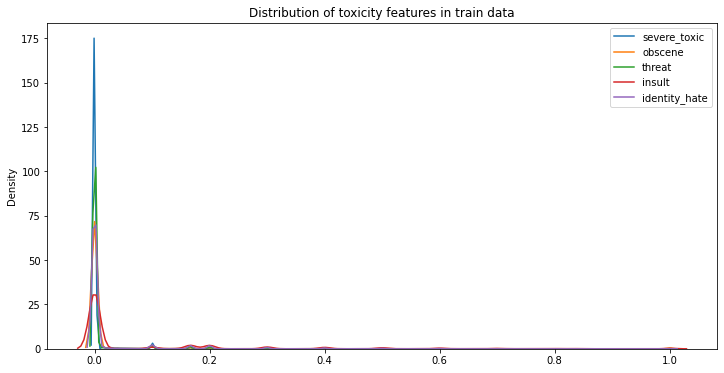

In [ ]:
attrs = ["severe_toxic", "obscene", "threat", "insult", "identity_hate"]
plt_attr_distribution(attrs, "Distribution of toxicity features in train data", train_data)

Now, we want to compute the percentage of toxic comments in all comments. 

In [ ]:
# sum all attribute values per row
total = train_data_labels.sum(axis=1)

# a comment is deemed toxic if any attribute is true (value>0 aka value.sum > 0) 
no_toxic = len([i for i in total if i >0])
# a comment is innocent if none of attribute is true 
no_innocent = len(total) - no_toxic

# 
percentage = {'% toxic_comments': [no_toxic/len(total)], '% innocent_comments': [no_innocent/len(total)]}
df2 = pd.DataFrame(data=percentage)

In [ ]:
#percentage toxic comments in training dataset
df2

,% toxic_comments,% innocent_comments
0,0.289007,0.710993


In [ ]:
# this function adds bar labels to the histogram
def autolabel(dataset, rects, labels):
    i=0
    for rect in rects:
        height = rect.get_height()
        dataset.annotate(s = str(labels[i])+'%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')
        i+=1

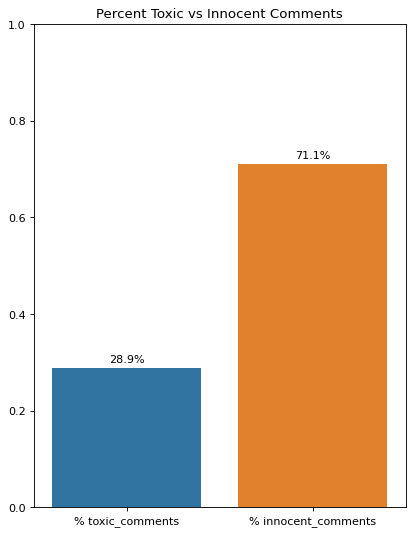

In [ ]:
# plot percentage toxic comments in training dataset
def plt_percentage_toxic(dataset,labels):
  figure(figsize=(6, 8), dpi=80)
  ax = sns.barplot(data=dataset)
  ax.set_title('Percent Toxic vs Innocent Comments')
  ax.set_ylim([0, 1])
  autolabel(ax, ax.patches,labels )

plt_percentage_toxic(df2,['28.9', '71.1'])

The distribution of the training dataset is skewed. There are more than 40% more non-toxic comments than toxic ones. The imbalanced dataset can impose challenges for predicting the minority class, which, in the case, is the toxic comments. 




### 3.2 Data visualisation - test dataset


In [ ]:
# Top 20 "Less Toxic" comments in test dataset
test_data['less_toxic'].value_counts().to_frame().head(20)

,less_toxic
How many sockpuppets do you have?,13
"sorry i jumped to conclusions \n\non christian terrorism article man, I don't agree with you, and I want you to go and listen to 'prophet of doom' (now in audio format) as it is good. But I was wrong to be so rude. It is not the Southern European way.",13
"Sockpuppet\nHi, would you please confirm this sockpuppet using the wiki-tools at you disposal and close both of their accounts. \n\nhttp://en.wikipedia.org/wiki/Wikipedia:Sockpuppet_investigations/Yomangani\n\nThank you",12
I erased your cuss word\nFrom: some random person out there in the world,12
this irishtom guy is turning every article into an ad for islam,12
"An addition comment of interest by Andrew Coyne National Post Dec 7th regarding Dion's dual citizenship-“Anyone who questions Stephan Dion’s patriotism is either a fool or a scoundrel. After the service he has done this country, after the abuse he has suffered in its name, to cast even the slightest doubt on his loyalty to Canada shames those who would try. There can be few Canadians who believe in their country more, or have done more to defend it.” \nThis tactic that the PC's are using regarding the citizenship issue is very much a copy of the Republic book. If somewhere an article or sourced information could be found it could be of interest to add as a counterbalance.",12
You vandalized the Flavor of Love acticle. Stop.I'm Warning you.,11
Support- stops the POV of nationalist editors,11
"""\n\n Please stop your disruptive editing. If your vandalism continues, you will be blocked from editing Wikipedia. andemu """,11
"Hello \n\nOK, don't try to frighten me with your a-hole threats about what you'll do in the real world. You and Nishkid, you related or what? Does your sage, soothing advice go to hell when soemone questions it?75.21.101.63",11


In [ ]:
# Top 20 "More Toxic" Comments in validation dataset
test_data['more_toxic'].value_counts().to_frame().head(20)

more_toxic
 YOU SUCK \n\nI HATE YOU> YOU CAN FUCK MY ASS A...          14
STUPID SPANISH CENTRALISTSTUPID SPANISH CENTRAL...          14
 PEOPLE ON THIS SITE SUCK  \n\nPEOPLE ON THIS S...          12
"\n\nBastard Child\nDoes anyone know if Obama w...          12
 go to hell \n\ngo to hell and leave me alone               12
MORON! The USA has only 5% of the worlds popula...          12
 INTEVIEW \n\nME: ARE YOU GAY?\n\nABE GAY DASHI...          12
 Imma cut off ur nutz and send em to ur gf \n\n...          12
LAST WARNING YOU FUCKING TOSSER, IT TAKES ME 10...          12
YOU'RE A FUCKING LIAR WHO DOESN'T KNOW HOW TO D...          12
ScJessey is a Big Fat Faggot Pinko Commie Asshole           12
Fuck you, Smith.  Please have me notified when ...          11
MOTHERFUCKER, DONT BE CHANGING THE FUCKING GTA ...          11
Stupidhead! Dweeb! How dare you say that! Scorp...          11
 Ok, what is it \n\nWhy are you such a queer.. ...          11
Why don't you just fuck off?                                11
fuck you jzg \n\ni will have you removed as edi...          11
Missrain4, I will make a rain of cum on your face.          11
|decline=Fucking bellend —                                  11
"\nNo, I'm not joking.  I'm hoping to help BD a...          11

We are not plotting the distribution of number of "less toxic" comments compared to "more toxic" ones, as the comments appear in pairs. 

### 3.3 N-gram features 

Word-level feature exploration with unigrams and bigrams 

3.3.1 Remove punctuations 

In [ ]:
def remove_punc(text):
  return text.translate(str.maketrans('', '', string.punctuation))

3.3.2 Lower case and Tokenize 

In [ ]:
def tokenizer(text):
  text = remove_punc(text)
  text = text.lower()
  tokens = nltk.word_tokenize(text)
  return tokens 

3.3.3 Remove Stop Words 

In [ ]:
# store a list of stopwords (common words that are not particularly useful for NLP analysis) 
stopWords = set(stopwords.words('english'))

# a list of stopwords but without the word "you".  
# this list, instead of the above list is used in bigram selection
stopWords_you =  set(stopwords.words('english')) - set(str("you"))


In [ ]:
def remove_stop(text):
  tokens = tokenizer(text)
  text_tokens = [token for token in tokens if token != '' if token not in stopWords]
  return text_tokens

3.3.4 Generate unigrams 

In [ ]:
def generate_unigrams(dataset, colname,ngram = 1):
  ngram_dict = defaultdict(int) 

  for rows in dataset[colname]:
    tokens = remove_stop(rows)
    for text in ngrams(tokens,ngram):
      ngram_dict[text] += 1    
  return pd.DataFrame(sorted(ngram_dict.items(), key=lambda x: x[1])[::-1])


3.3.4 Generate bigrams 

In [ ]:
def generate_bigrams(dataset, colname):
  ngram_dict = defaultdict(int) 

  for rows in dataset[colname]:
    tokens = remove_stop(rows)
    for text in ngrams(tokens,2):
      ngram_dict[text] += 1 
    
  return pd.DataFrame(sorted(ngram_dict.items(), key=lambda x: x[1])[::-1])

**Unigrams for test data**

In [ ]:
# get unigrams for test data
df_less_toxic_unigrams = generate_unigrams(test_data,colname = 'less_toxic')
df_more_toxic_unigrams = generate_unigrams(test_data,colname = 'more_toxic')


In [ ]:
#select the top 50 unigrams associated with more and less toxic comments in test dataset
unigrams_more_toxic_top50 = df_more_toxic_unigrams[:50]
unigrams_less_toxic_top50 = df_less_toxic_unigrams[:50]

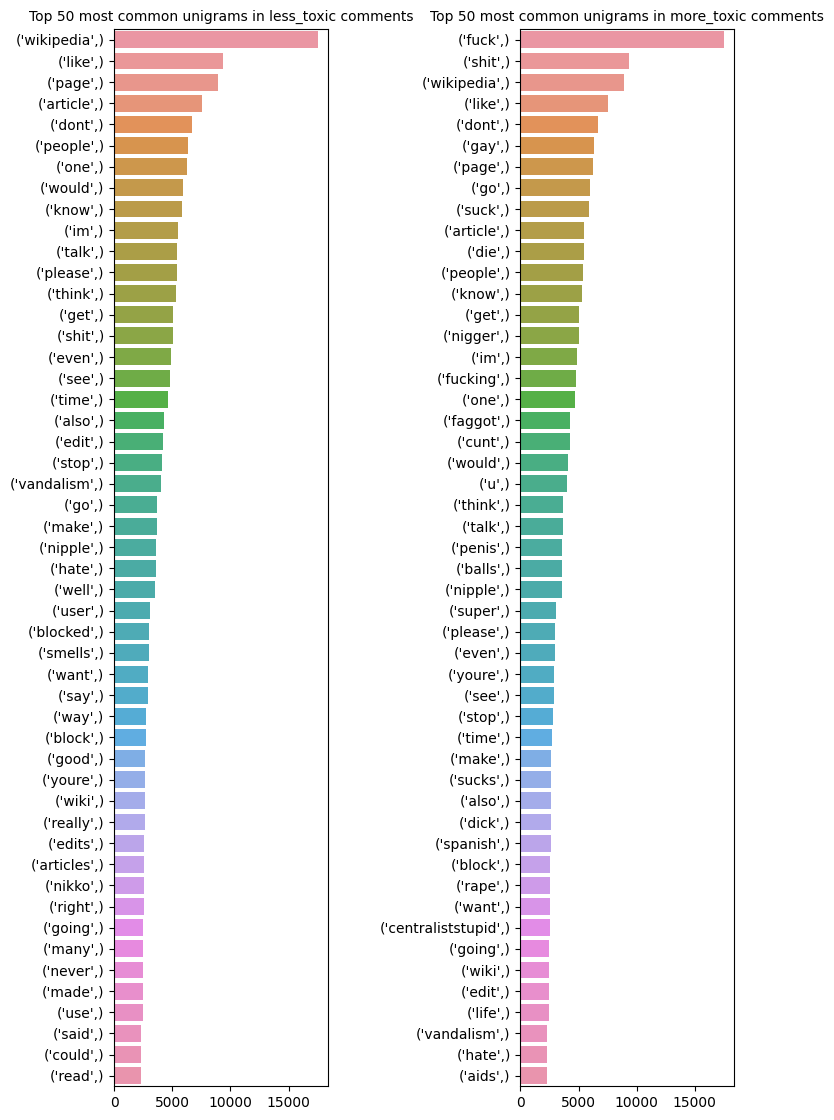

In [ ]:
#plot the top 50 words in less toxic comments in test dataset

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 14),dpi=100)
plt.tight_layout(pad=20)
sns.barplot(y=unigrams_less_toxic_top50[0], x=unigrams_more_toxic_top50[1],ax=axes[0])
sns.barplot(y=unigrams_more_toxic_top50[0], x=unigrams_more_toxic_top50[1],ax=axes[1])

axes[0].set_title(f'Top 50 most common unigrams in less_toxic comments', fontsize=10)
axes[1].set_title(f'Top 50 most common unigrams in more_toxic comments', fontsize=10)

axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.subplots_adjust(wspace = 0.9)
plt.show()

**Unigrams for train data subset**

We use 10% of the total training dataset for unigram selection, as the total dataset is too large (~ 2 million samples)

In [ ]:
train_subset = train_data.sample(frac=0.1)
train_subset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,dataset,comment_text_processed
1719298,5847199,"We have a Charter of Rights in Canada, it prot...",0.166667,0.0,0.0,0.0,0.166667,0.000000,unintended,we have a charter of rights in canada it prote...
1136526,7184341,I think raising the carbon tax and foreign buy...,0.000000,0.0,0.0,0.0,0.000000,0.000000,unintended,i think raising the carbon tax and foreign buy...
702720,5411810,Ever talk to these people IRL? It seemed like ...,0.000000,0.0,0.0,0.0,0.000000,0.000000,unintended,ever talk to these people irl it seemed like n...
1275657,7026087,We're talking about federal tax law. Ontario i...,0.000000,0.0,0.0,0.0,0.000000,0.000000,unintended,we're talking about federal tax law ontario is...
1987017,6165574,Non-issue? Perhaps you missed Trudeau's electi...,0.166667,0.0,0.0,0.0,0.000000,0.166667,unintended,non issue perhaps you missed trudeau's electio...


In [ ]:
train_subset_labels = train_subset[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
total = train_subset_labels.sum(axis=1)

# a comment is deemed toxic if any attribute is true (value>0 aka value.sum > 0) 
no_toxic = len([i for i in total if i >0])
# a comment is innocent if none of attribute is true 
no_innocent = len(total) - no_toxic

count = {'% toxic_comments': [no_toxic/len(total)], '% innocent_comments': [no_innocent/len(total)]}
df3 = pd.DataFrame(data=count)

In [ ]:
df3

,% toxic_comments,% innocent_comments
0,0.290698,0.709302


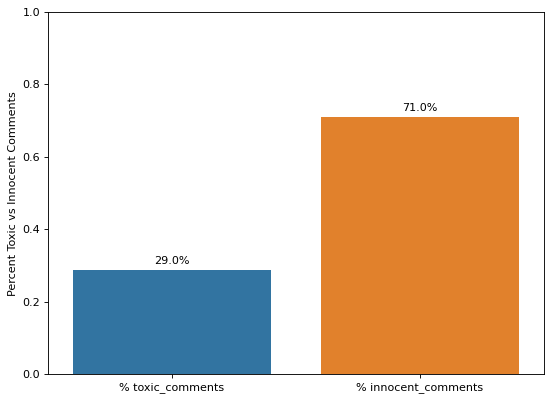

In [ ]:
# plot the distribution of toxic and non-toxic comments in the subset of train data
plt_percentage_toxic(df2,['29.0', '71.0'])

In [ ]:
colnames = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# the train dataset has 6 different labels. 
# The data also has different structure compared to the test data
# we need to define a new function to produce unigrams for train data
def generate_unigram_for_traindata(colname):

  #generate names for each column/label
  target_col = str("train_subset_") + colname
  unigram_set_name = target_col + str('_unigram_top50')

  # we only want to process samples with the attribute (aka attr.value!=0)
  target_col = train_subset.loc[((train_subset[colname] >0.0))]

  # generate unigrams then take the top 50
  unigram_set_name =generate_unigrams(target_col,colname = 'comment_text')[:50]
  return unigram_set_name

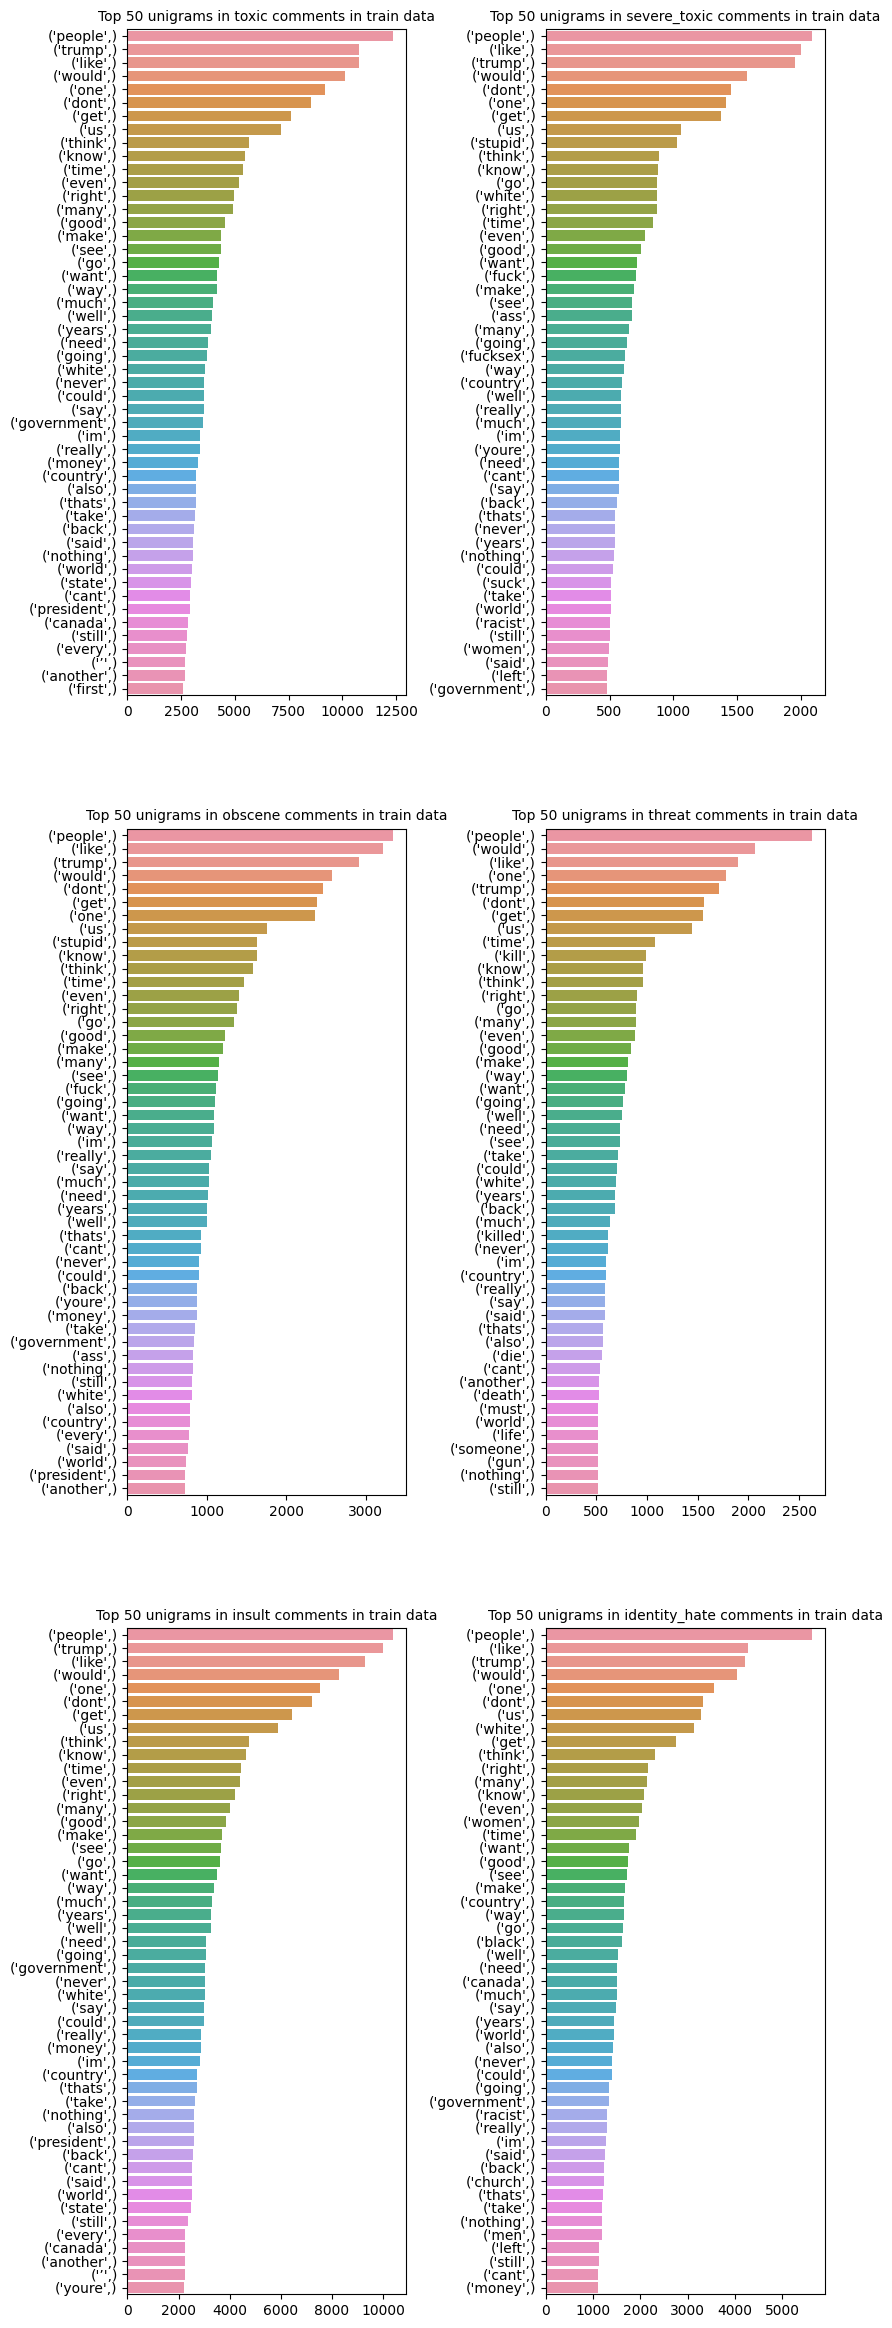

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 30),dpi=100)
plt.tight_layout(pad=20)

counter = -1 
for i in colnames:
  counter += 1 
  if counter < 2:
    nrow,ncol = 0, counter 
  elif counter>=2 and counter <4:
    nrow,ncol = 1, counter-2 
  else:
    nrow,ncol = 2, counter-4
  unigram_graph_input = generate_unigram_for_traindata(i)
  sns.barplot(y=unigram_graph_input[0], x=unigram_graph_input[1],ax=axes[nrow,ncol])
  axes[nrow,ncol].set_title('Top 50 unigrams in {} comments in train data'.format(i), fontsize=10)
  axes[nrow,ncol].set_xlabel('')
  axes[nrow,ncol].set_ylabel('')

  plt.subplots_adjust(wspace = 0.5)
plt.show()

Many common uniqrams appear in "toxic" class also appear in other toxicity features. 



**Bigrams for test data**

In [ ]:
df_less_toxic_bigrams = generate_bigrams(test_data,colname = 'less_toxic')
df_more_toxic_bigrams = generate_bigrams(test_data,colname = 'more_toxic')

In [ ]:
#select the top 50 bigrams associated with more and less toxic comments in test data
bigrams_less_toxic_top50 = df_less_toxic_bigrams[:50]
bigrams_more_toxic_top50 = df_more_toxic_bigrams[:50]

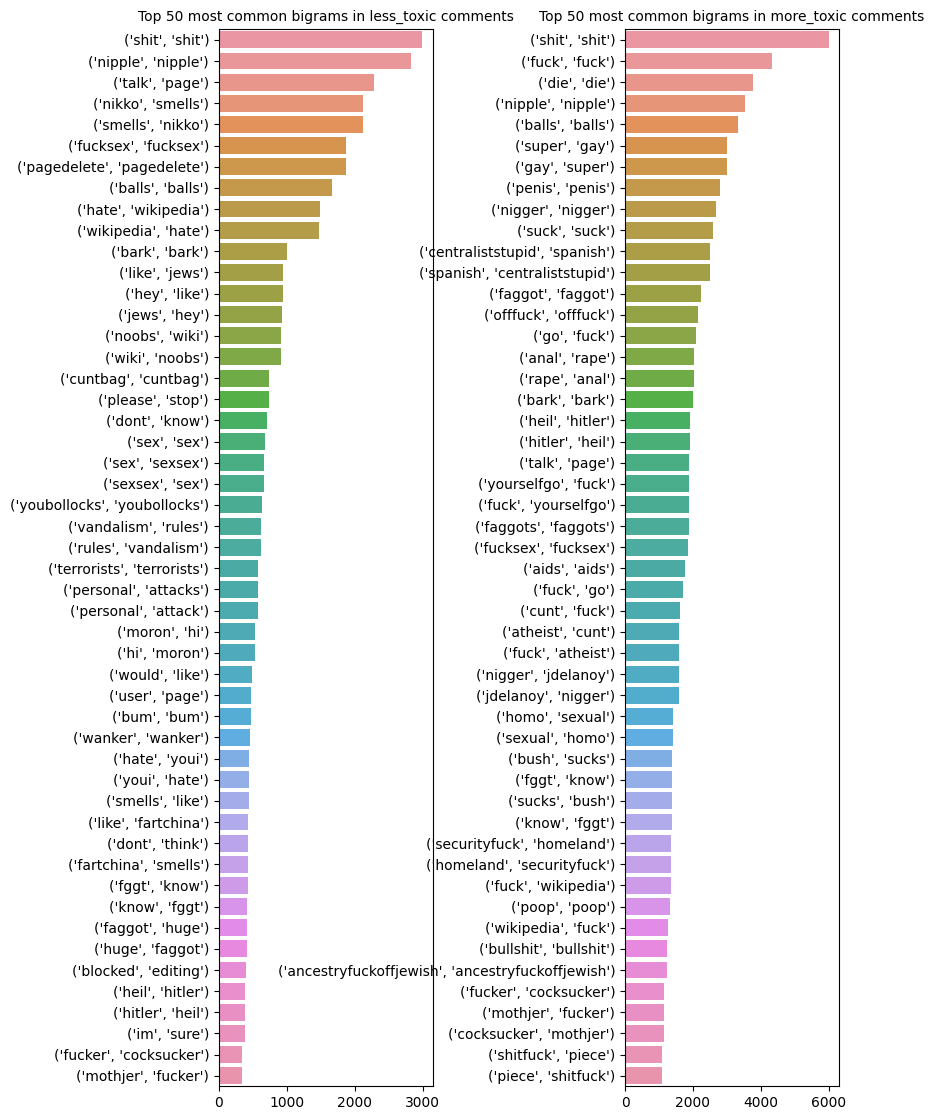

In [ ]:
#plot the top 50 words in less toxic comments in test data

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 14),dpi=100)
plt.tight_layout(pad=20)
sns.barplot(y=bigrams_less_toxic_top50[0], x=bigrams_less_toxic_top50[1],ax=axes[0])
sns.barplot(y=bigrams_more_toxic_top50[0], x=bigrams_more_toxic_top50[1],ax=axes[1])

axes[0].set_title(f'Top 50 most common bigrams in less_toxic comments', fontsize=10)
axes[1].set_title(f'Top 50 most common bigrams in more_toxic comments', fontsize=10)

axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.subplots_adjust(wspace = 0.9)
plt.show()

**Bigram for train data subset**

In [ ]:
def generate_bigram_for_traindata(colname):

  #generate names for each column/label
  target_col = str("train_subset_") + colname
  bigram_set_name = target_col + str('_bigram_top50')

  # we only want to process samples with the attribute (aka attr.value!=0)
  target_col = train_subset.loc[((train_subset[colname] >0.0))]

  # generate unigrams then take the top 50
  bigram_set_name =generate_bigrams(target_col,colname = 'comment_text')[:50]
  return bigram_set_name

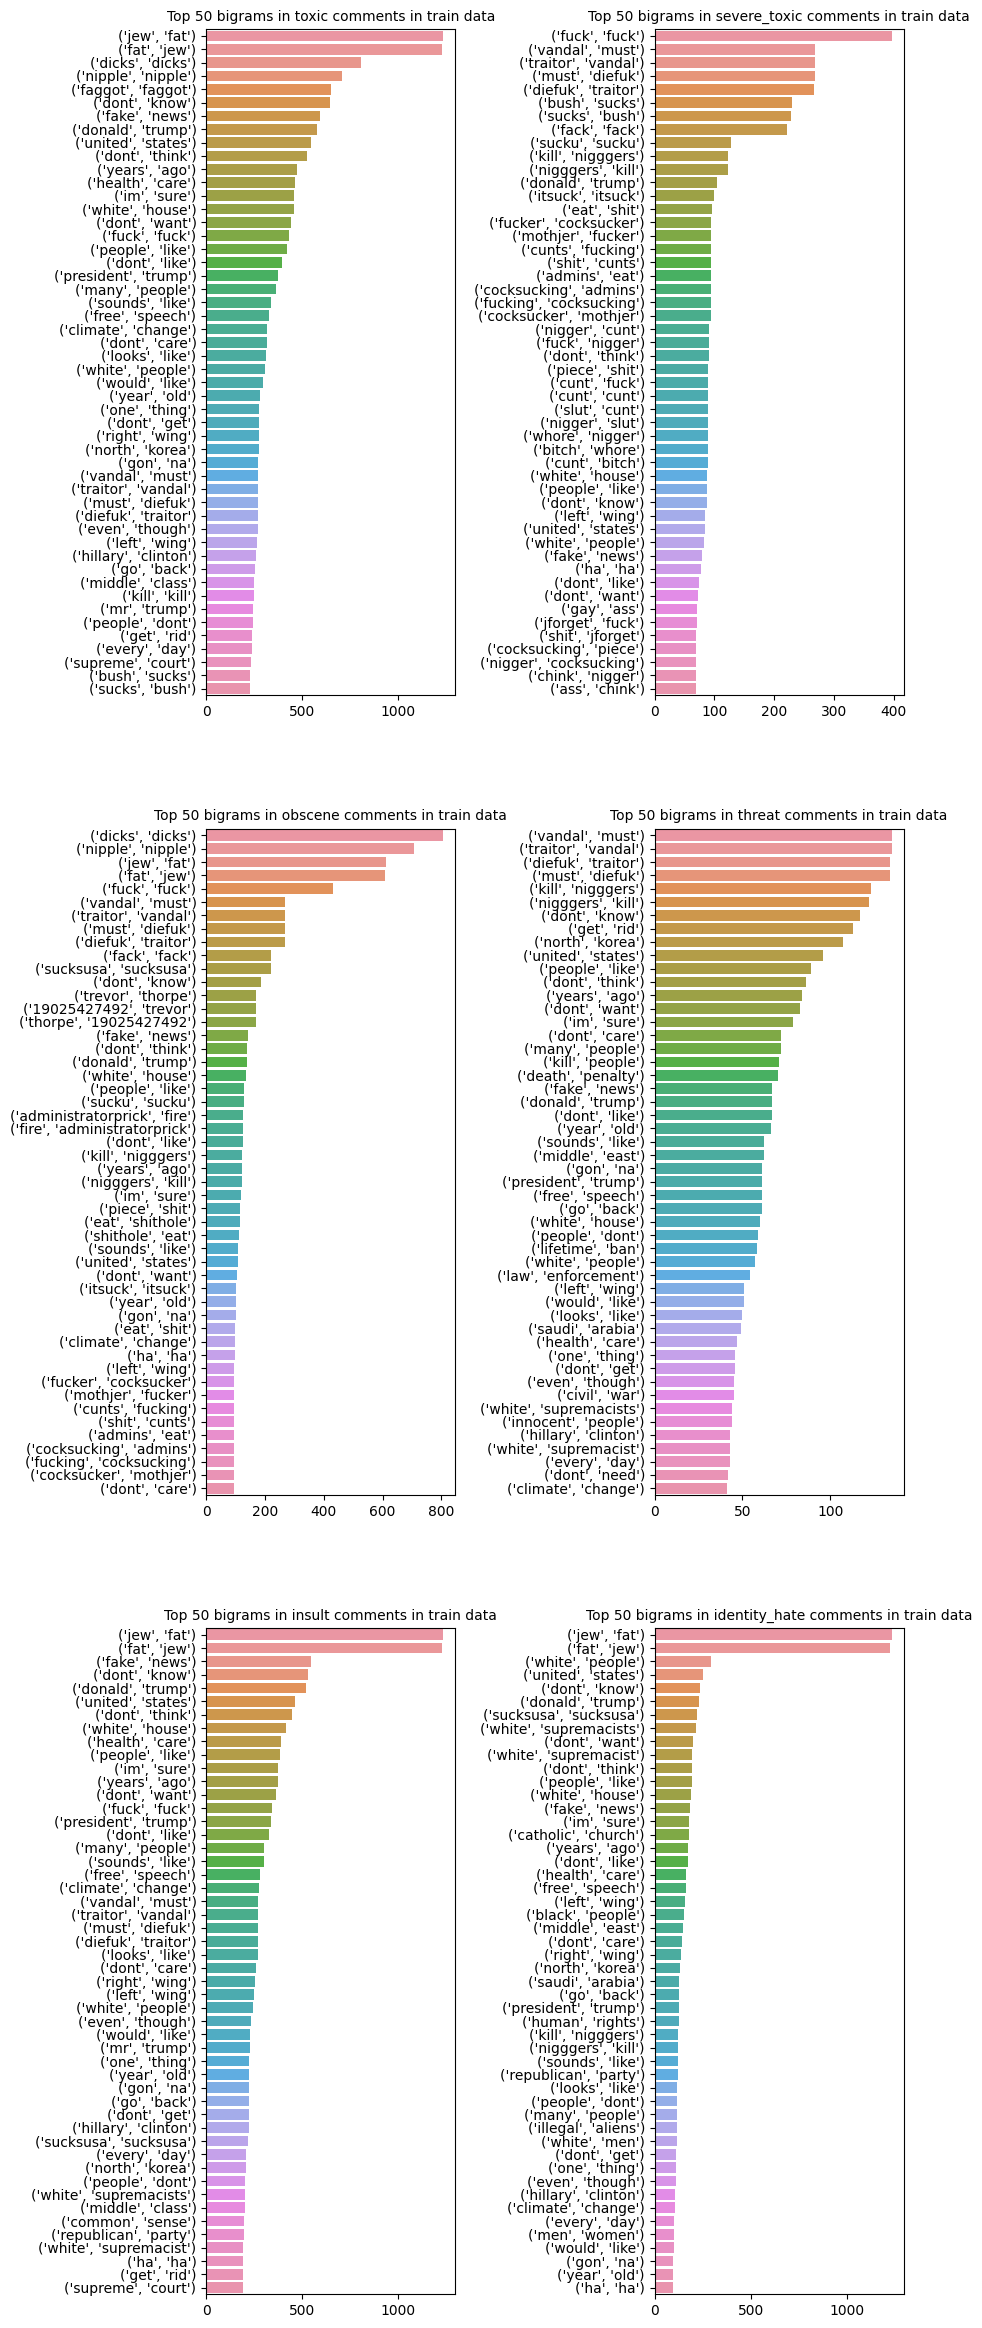

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 30),dpi=100)
plt.tight_layout(pad=20)


counter = -1 
for i in colnames:
  counter += 1 
  if counter < 2:
    nrow,ncol = 0, counter 
  elif counter>=2 and counter <4:
    nrow,ncol = 1, counter-2 
  else:
    nrow,ncol = 2, counter-4
  bigram_graph_input = generate_bigram_for_traindata(i)
  sns.barplot(y=bigram_graph_input[0], x=bigram_graph_input[1],ax=axes[nrow,ncol])
  axes[nrow,ncol].set_title('Top 50 bigrams in {} comments in train data'.format(i), fontsize=10)
  axes[nrow,ncol].set_xlabel('')
  axes[nrow,ncol].set_ylabel('')

  plt.subplots_adjust(wspace = 0.8)
plt.show()


## 3.5 LDA 
Latent Dirichlet Allocation (LDA) is used to discover the topics that are present in a corpus.




**LDA for test dataset**

In [ ]:
unique_comments=pd.DataFrame(test_data["more_toxic"].unique().tolist()+test_data["less_toxic"].unique().tolist())

In [ ]:
unique_comments.head()

,0
0,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,Daphne Guinness \n\nTop of the mornin' my fav...
2,"""Atom you don't believe actual photos of mastu..."
3,You seem to have sand in your vagina.\n\nMight...
4,"hey \n\nway to support nazis, you racist"


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words="english",
                       max_df=.1,
                       max_features=500) # focus on top 500 features

#transform a text into a vector according frequency (count) of each word
test_vx=count.fit_transform(unique_comments[0].values)

In [ ]:
test_vx[10].toarray(),unique_comments.iloc[10]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0

Using LDA to identify the top n words with highest probability for a topic, which describes this topic

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as lda
lda=lda(n_components=10,random_state=42,learning_method="batch")
test_topics=lda.fit_transform(test_vx)

In [ ]:
n_top_words=5
# show the top 5 words for each topic 
feature_names = count.get_feature_names()
def get_top_5():
  for topic_idx, topic in enumerate(lda.components_):
      print("Topic %d:" % (topic_idx+1))
      print(" ".join([feature_names[i] for i in topic.argsort() \
                    [:-n_top_words-1:-1]]))
get_top_5()

Topic 1:
nipple penis say make use
Topic 2:
cunt fucksex damn http faggots
Topic 3:
suck hey dick jews love
Topic 4:
wiki hate noobs bitches bullshit
Topic 5:
faggot bark gay huge aids
Topic 6:
user blocked block edit edits
Topic 7:
shit vandalism nigger rules stop
Topic 8:
smells nikko pagedelete super gay
Topic 9:
sex ve good way time
Topic 10:
fuck fucking balls die ass


**LDA for train dataset**

In [ ]:
train_subset.head() 

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,dataset,comment_text_processed
1719298,5847199,"We have a Charter of Rights in Canada, it prot...",0.166667,0.0,0.0,0.0,0.166667,0.000000,unintended,we have a charter of rights in canada it prote...
1136526,7184341,I think raising the carbon tax and foreign buy...,0.000000,0.0,0.0,0.0,0.000000,0.000000,unintended,i think raising the carbon tax and foreign buy...
702720,5411810,Ever talk to these people IRL? It seemed like ...,0.000000,0.0,0.0,0.0,0.000000,0.000000,unintended,ever talk to these people irl it seemed like n...
1275657,7026087,We're talking about federal tax law. Ontario i...,0.000000,0.0,0.0,0.0,0.000000,0.000000,unintended,we're talking about federal tax law ontario is...
1987017,6165574,Non-issue? Perhaps you missed Trudeau's electi...,0.166667,0.0,0.0,0.0,0.000000,0.166667,unintended,non issue perhaps you missed trudeau's electio...


In [ ]:
comments=pd.DataFrame(train_subset["comment_text"].unique())

In [ ]:
train_vx=count.fit_transform(comments[0].values)

In [ ]:
train_topics=lda.fit_transform(train_vx)

In [ ]:
n_top_words=5
# show the top 5 words for each topic 
feature_names = count.get_feature_names()
get_top_5()

Topic 1:
canada city trudeau canadian know
Topic 2:
did party news mr media
Topic 3:
article use does think church
Topic 4:
page talk want ll wikipedia
Topic 5:
com right www http comment
Topic 6:
years time women long school
Topic 7:
money tax pay state oil
Topic 8:
country government law states american
Topic 9:
year new need 000 change
Topic 10:
trump president obama man clinton


## Data Preprocessing

The preprocessing at this step is mainly served to clean the text.  
Besides, we sample and divide the data to get training and validation set  
which are used to train our models

In [ ]:
def preprocess(text):
  try:
    # remove url prefix
    urls = re.findall(r'(https?://)', text)
    if len(urls) != 0:
        for url in urls:
            text = text.replace(url, " url ")
    # remove \n
    text = re.sub("\n", " ", text)
    # remove punctuations 
    text = re.sub("([\"·!#\\$%&\\(\\)\\*\\+,-\\.\\/:;<=>\\?@\\[\\\\\]\\^_`{\\|}~]+)", r" ", text)
    # trim repeating charaters
    text = re.sub(r"(.)\1\1{3,}", r"\1", text)
    text = re.sub(r'[ ]{2,}',' ', text).strip()
    text = re.sub(r'([?!*]){2,}',r"\1", text).strip()
    return text
  except TypeError:
    print(text)
    return "Nan"

# use a test case to test if it succesfully cleans text
test_case = ["https://D'aillers      ad(dddd)dsda#$\\]%^@sd\n",
             "pio\"nee\"r??? yesssss!!!!!!!  ",
             "this (is) some $ kind#@#@ thing??? ",
             "WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!=\nWHER IS YOUR SEXY PIC GONE FROM YOUR MAIN PAGE???????? put it back"]
for t in test_case:
  print(repr(preprocess(t)))

read in data and clean the whole dataset

In [ ]:
data_path = "data/data.csv"
data = pd.read_csv(data_path)
data['processed_text'] = data['comment_text'].map(preprocess)

get the toxicity level as we'll use it for regression

In [ ]:
###### get toxicity level ######
def get_sum(row):
  return sum([row['toxic'], row['severe_toxic'], row['obscene'], row['threat'], row['insult'], row['identity_hate']])
data['level'] = data.apply(lambda x: get_sum(x), axis=1)

get the tokenized text to train word2vec model

In [ ]:
def tokenize_lower(text):
  text = text.split(" ")
  text = list(map(lambda x:x.strip(), text))
  text = list(map(lambda x:x.lower(), text))
  text = list(filter(None, text))
  return text
# we don't use pandas map because it needs more memory 
tokenized_text = []
for i in tqdm(data['processed_text']):
  tokenized_text.append(tokenize_lower(i))
data['tokenized_text'] = tokenized_text
del tokenized_text
gc.collect()

divide the continuous toxicity level into discret ordinal range

In [ ]:
# normalize first
level = np.array(data.level).reshape((-1, 1))
min_max_scaler = preprocessing.MinMaxScaler()
level_scaled = min_max_scaler.fit_transform(level)
level_scaled = level_scaled.squeeze()
data['normalized_level'] = level_scaled
# create range
score_range = [0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
def score_to_range(score):  
  for cls, value in enumerate(score_range):
    if score >= value:
      return cls 
data['range_cls'] = data['normalized_level'].map(score_to_range)

From the data exploration part, we can see that  
the distribution of the labels are very imbalanced. 
The class with label 0 can take up to 70%,  
while data in some range only takes up less than 5%.  
Thus, we sample the data so that there's an even number of samples among different classes.

In [ ]:
sampled_data = data.groupby('range_cls').apply(lambda x: x.sample(3000)) # 3000 is the number of samples of the label which has the least amount of data
sampled_data = sampled_data.dropna(subset=['processed_text']) # clear rows which has na for its text content

We use a held-out strategy for the validation of model. 

In [ ]:
train_data_sampled, test_data_sampled = train_test_split(sampled_data, train_size=0.9)

## Model 

### sentence embedding 

#### TF-IDF 

In [ ]:
tfidf_vec = TfidfVectorizer()
tfidf_vectorizer = tfidf_vec.fit(sampled_data['processed_text'])
tfidf_feats_train = tfidf_vectorizer.transform(train_data_sampled['processed_text'])
tfidf_feats_test = tfidf_vectorizer.transform(test_data_sampled['processed_text'])

#### Train a word2vec model

When we train the word2vec model, we use all of the original data since the training of word2ve is faster than tf-idf.

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print('Loss after epoch {}: {}'.format(self.epoch, loss))
        self.epoch += 1
        print(self.epoch)

texts = list(data["processed_text"])
print(len(texts))
class TokenizedText:
  def __init__(self, data):
    self.data = data

  def __iter__(self):
    self.length = len(self.data)
    self.cnt = 0
    return self

  def __next__(self):
    if self.cnt < self.length:
      sent = self.data[self.cnt]
      self.cnt += 1
      return tokenize_lower(sent)
    
    else:
      raise StopIteration

corpus = TokenizedText(texts)
# an alternative approch is to use LineSentence utility provided by gensim
# it's more memory-friendly
with open("corpus.txt", "w") as f:
  for text in tqdm(data["processed_text"]):
    tokens = tokenize_lower(text)
    for i in tokens:
      f.write(i)
      f.write(" ")
    f.write("\n")
corpus = LineSentence("corpus.txt")


train and save the model

In [ ]:
w2vmodel = Word2Vec(sentences = corpus, size = 150, window=5, min_count=1, workers=-1, compute_loss=True)
w2vmodel.save("data/w2vmodel_wholedata.model")

We use an average pooling strategy to get the sentence embedding

In [ ]:
def get_sentvec(model, sent):
  # sent is a tokenized string, type:list
  concat = []
  for word in sent:
    try:
      concat.append(model.wv[word])
    except KeyError:
      print(word)
      pass

  concat_vec = np.vstack(concat)
  res = np.mean(concat_vec,keepdims=True, axis = 0)
  return res


Use Word2vec to get features from dataset

In [ ]:
def get_feat_label(train_data_sampled):
  train_features = []
  train_labels = list(train_data_sampled['range_cls'])
  for i in train_data_sampled['processed_text']:
    tokens = tokenize_lower(i)
    vec = get_sentvec(w2vmodel, tokens)
    train_features.append(vec)
  feat = np.vstack(train_features)

  assert feat.shape[0] == len(train_labels)
  return feat, train_labels

train_features, train_labels = get_feat_label(train_data_sampled)
test_features, test_labels = get_feat_label(test_data_sampled)

#### Universal Sentence Encoder

In [ ]:
embed = hub.load("./data/universal_model")
def get_features(embed, sents):
  res = []
  for i in tqdm(range(0, len(sents), 50)):
    embeddings = embed(sents[i:i+50])
    res.append(np.array(embeddings))

  res = np.vstack(res)
  return res
train_sents = train_data_sampled["processed_text"]
test_sents = test_data_sampled["processed_text"]
train_feats_enc = get_features(embed, train_sents )
test_feats_enc = get_features(embed, test_sents )


### Build Models

##### Strategy1: classification

In [ ]:
def get_pred(model):
  # the function to test the model
  # given a dataset of pairs of texts
  # return the total number of correctly ranked pairs
  res = []
  for i in range(len(test_data)):
    s = test_data.iloc[i]
    less = s.less_toxic
    more = s.more_toxic
    less = preprocess(less)
    more = preprocess(more)
    less_feat = tfidf_vectorizer.transform([less])
    more_feat = tfidf_vectorizer.transform([more])

    prob_less = model.predict_proba(less_feat)
    prob_more = model.predict_proba(more_feat)

    score_less = sum([p*s for p, s in zip(prob_less[0], score_range)])
    score_more =  sum([p*s for p, s in zip(prob_less[0], score_range)])
   
    if score_less < score_more:
      res.append(1) 
    else:
       res.append(0)
  return sum(res)

Use TF-IDF as embedding 

In [ ]:
# Logistic Regression
logit_clf = LogisticRegression(max_iter = 500).fit(tfidf_feats_train, train_data_sampled['range_cls'])
logit_test = logit_clf.predict())
print(classification_report(logit_test, test_data_sampled['range_cls']))

# SVM
svm_clf = SVC().fit(tfidf_feats_train, train_data_sampled['range_cls'])
svc_test = svm_clf.predict(tfidf_feats_test)
print(classification_report(svc_test, test_data_sampled['range_cls']))

# Random Forest
rd_clf = RandomForestClassifier(n_estimators=15).fit(tfidf_feats_train, train_data_sampled['range_cls'])
rf_test = rd_clf.predict(tfidf_feats_test)
print(classification_report(rf_test, test_data_sampled['range_cls']))

Use Word2vec as embedding 

In [ ]:
# Logistic Regression
logit_clf = LogisticRegression(max_iter = 500).fit(train_features, train_labels)
logit_test = logit_clf.predict(test_features)
print(classification_report(logit_test, test_labels))


The performance of strategy 1 is very poor under both embeddings of tf-idf and word2vec, so we stop the strategy 1 here.  
However, the poor performance may be more likely due to the selection of range.  Time permitted, more comparison can be done under different ranges.

##### Strategy2: regression

In [ ]:
# show the regression metrics of the model 
def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
# when using tf-idf, get the total number of correctly ranked pairs
def get_pred_reg(model):
  res = []
  for i in tqdm(range(len(test_data))):
    s = test_data.iloc[i]
    less = s.less_toxic
    more = s.more_toxic
    less = preprocess(less)
    more = preprocess(more)
    less_feat = tfidf_vectorizer.transform([less])
    more_feat = tfidf_vectorizer.transform([more])


    score_less = model.predict(less_feat)
    score_more = model.predict(more_feat)

    if score_less < score_more:
      res.append(1) 
    else:
      res.append(0)
  return res

# when using word2vec, get the total number of correctly ranked pairs
def get_pred_reg_w2v(model):
  res = []
  for i in tqdm(range(len(test_data))):
    s = test_data.iloc[i]
    less = s.less_toxic
    more = s.more_toxic
    less = preprocess(less)
    more = preprocess(more)
    less_feat = get_sentvec(w2vmodel, tokenize_lower(less))
    more_feat = get_sentvec(w2vmodel, tokenize_lower(more))
    score_less = model.predict(less_feat)
    score_more = model.predict(more_feat)

    if score_less < score_more:
      res.append(1) 
    else:
      res.append(0)
  return res

Ridge Regression 

In [ ]:
# TF-IDF 
ridge = Ridge().fit(tfidf_feats_train, train_data_sampled['level'])
lr_pred = ridge.predict(tfidf_feats_test)
regression_results(test_data_sampled['level'], lr_pred)
ridge_res = get_pred_reg(ridge)
print(sum(ridge_res)/len(ridge_res))

# word2vec
ridge = Ridge().fit(train_features, train_data_sampled['level'])
lr_pred = ridge.predict(test_features)
regression_results(test_data_sampled['level'], lr_pred)
ridge_res = get_pred_reg_w2v(ridge)
print(sum(ridge_res)/len(ridge_res))

Support Vector Regression

In [ ]:
# TF-IDF 
svr = SVR().fit(tfidf_feats_train, train_data_sampled['level'])
svr_pred = svr.predict(tfidf_feats_test)
regression_results(test_data_sampled['level'], svr_pred)
svr_res = get_pred_reg(svr)
sum(svr_res)/len(svr_res)

# word2vec
svr = SVR().fit(train_features, train_data_sampled['level'])
svr_pred = svr.predict(test_features)
regression_results(test_data_sampled['level'], svr_pred)
svr_res = get_pred_reg_w2v(svr)
sum(svr_res)/len(svr_res)

Random Forest 

In [ ]:
# TF-IDF 
rf = RandomForestRegressor(n_estimators=25).fit(tfidf_feats_train, train_data_sampled['level'])
rf_pred = rf.predict(tfidf_feats_test)
regression_results(test_data_sampled['level'], rf_pred)
rf_res = get_pred_reg(rf)
sum(rf_res)/len(rf_res)

# word2vec 
rf = RandomForestRegressor(n_estimators=25).fit(train_features, train_data_sampled['level'])
rf_pred = rf.predict(test_features)
regression_results(test_data_sampled['level'], rf_pred)
rf_res = get_pred_reg_w2v(rf)
sum(rf_res)/len(rf_res)

We choose the model having the best performance, and use universal sentence encoder as embedding method to rank the texts in pairs.

In [ ]:
# when using universa sentence encoder, get the total number of correctly ranked pairs
def get_pred_reg_enc(model):
  res = []
  less_list = []
  more_list = []
  for i in range(len(test_data)):
    s = test_data.iloc[i]
    less = s.less_toxic
    more = s.more_toxic

    less = preprocess(less)
    more = preprocess(more)
    less_list.append(less)
    more_list.append(more)
  less_feat = []
  more_feat = []

  for i in tqdm(range(0, len(less_list), 50)):
    embeddings = embed(less_list[i:i+50])
    less_feat.append(np.array(embeddings))

  for i in tqdm(range(0, len(more_list), 50)):
    embeddings = embed(more_list[i:i+50])
    more_feat.append(np.array(embeddings))
  print("embedding done")
  less_feat = np.vstack(less_feat)
  more_feat = np.vstack(more_feat)
  print("predicting less...")
  score_less = model.predict(less_feat)
  print("predicting more...")
  score_more = model.predict(more_feat)


  return score_less, score_more

In [ ]:
svr = SVR().fit(train_feats_enc, train_data_sampled['level'])
svr_pred = svr.predict(test_feats_enc)
regression_results(test_data_sampled['level'], svr_pred)
svr_res = get_pred_reg_enc(svr)
sum(svr_res)/len(svr_res)
score_less, score_more = get_pred_reg_enc(svr)
cnt = 0
for j, k in zip(score_less, score_more):
  if j< k :
    cnt += 1
print(cnt/len(score_less))

##### SVM Rank

We use the svm rank tools provided at   https://www.cs.cornell.edu/people/tj/svm_light/svm_rank.html

Format the data so that it can be used for svm rank tools

In [ ]:
train_scores = list(train_data_sampled['level'])
test_scores = list(test_data_sampled['level'])
with open("data/train.dat", "w", encoding="utf-8") as f:
  for i in range(train_features.shape[0]): 
    vec = train_features[i]
    f.write(str(train_scores[i]))
    f.write(" qid:1 ")
    for idx, v in enumerate(vec):
      f.write(str(idx+1)+":"+str(v))
      f.write(" ")
    f.write("\n")

with open("data/test.dat", "w", encoding="utf-8") as f:
  for i in range(test_features.shape[0]): 
    vec = test_features[i]
    f.write(str(test_scores[i]))
    f.write(" qid:1 ")
    for idx, v in enumerate(vec):
      f.write(str(idx+1)+":"+str(v))
      f.write(" ")
    f.write("\n")           

format the test data, and get the prediction using svm rank

In [ ]:
with open("data/valid.dat", "w", encoding="utf-8") as f:
  for i in tqdm(range(len(test_data))):
    s = test_data.iloc[i]
    less = s.less_toxic
    more = s.more_toxic
    less = preprocess(less)
    more = preprocess(more)
    less_feat = get_sentvec(w2vmodel, tokenize_lower(less))
    more_feat = get_sentvec(w2vmodel, tokenize_lower(more))
    f.write(" qid:1 ")
    for idx, v in enumerate(less_feat[0]):
      f.write(str(idx+1)+":"+str(v))
      f.write(" ")
    f.write("\n")
    f.write(" qid:1 ")
    for idx, v in enumerate(more_feat[0]):
      f.write(str(idx+1)+":"+str(v))
      f.write(" ")
    f.write("\n")
    
# pass the above file to svm rank and get prediction as pred.dat
correct_cnt = 0
with open("data/pred.dat", "r") as f:
  lines = f.readlines()
  for i in range(0, len(lines), 2):
    less = float(lines[i].strip("\n"))
    more = float(lines[i+1].strip("\n"))
    if less < more:
      correct_cnt += 1
print(correct_cnt/len(test_data))